In [1]:
%load_ext Cython

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from tqdm import tqdm
from scipy.special import erfc
import boost_histogram as bh

from lmfit.models import *
from lmfit import Model

import inspect

In [3]:
golden_df = pd.read_csv("/Users/tylern/Data/e1d/gr.csv")
print(len(golden_df))
golden_df = golden_df.groupby(golden_df['run_num'], as_index=False).aggregate({'run_num': 'first', 'num_elec': 'sum', 'num_of_events': 'sum', 'total_q': 'sum'})
golden_df['ratio'] = golden_df['num_of_events'] / golden_df['total_q']
# golden_df['run'] = golden_df.run_num*10 + golden_df.file_num
#golden_df = golden_df.sort_values(by=['run_num', 'file_num']).reset_index()
golden_df = golden_df.sort_values(by=['run_num']).reset_index()
golden_df['sum_q'] = np.cumsum(golden_df['total_q'])

golden_df.head()

2338


,index,run_num,num_elec,num_of_events,total_q,ratio,sum_q
0,0,22848,206167,206200,34.602299,5959.141539,34.602299
1,1,22853,1388871,1389076,220.698300,6294.004080,255.300599
2,2,22880,12470,12529,0.850000,14739.999587,256.150599
3,3,22882,497046,497229,544.372902,913.397780,800.523501
4,4,22884,617835,617950,64.988001,9508.678398,865.511502


In [4]:
run_list = pd.read_csv("/Users/tylern/Data/e1d/out.csv").rename(columns={"Run Id": "run_num"})
run_list['Number of Events'] = pd.to_numeric(run_list['Number of Events'], errors='coerce')
run_list.head()

,run_num,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,22678,2000-01-31 10:16:00.0,1645.03,0.0,0.977,0,27380.0,e_calib_misc,56Fe
1,22679,2000-01-31 10:29:00.0,1645.03,0.0,0.977,0,32546.0,e_calib_misc,56Fe
2,22680,2000-01-31 10:35:00.0,1645.03,0.0,0.977,0,555588.0,e_calib_misc,56Fe
3,22681,2000-01-31 14:47:00.0,1645.03,0.0,-0.977,0,980.0,e_calib_misc,other
4,22682,2000-01-31 14:52:00.0,1645.03,0.0,0.977,0,1133.0,e_calib_misc,other


In [5]:
golden = pd.merge(golden_df, run_list, on='run_num')
#golden = golden_df
empty = golden[golden.Target == "empty"]
golden = golden[(golden.Target == "H2_full") & (golden["Run Type"] == 'beam_electron')]
golden.dropna(inplace=True)
print(len(golden))
golden.head(10)

238


,index,run_num,num_elec,num_of_events,total_q,ratio,sum_q,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,0,22848,206167,206200,34.602299,5959.141539,34.602299,2000-02-04 02:20:00.0,4817.26,5.0,3376.80,5996,5061135.0,beam_electron,H2_full
1,1,22853,1388871,1389076,220.698300,6294.004080,255.300599,2000-02-04 05:30:00.0,4817.26,5.0,3376.80,5996,4961938.0,beam_electron,H2_full
4,4,22884,617835,617950,64.988001,9508.678398,865.511502,2000-02-05 02:31:00.0,4817.26,4.0,3372.89,5996,2054237.0,beam_electron,H2_full
5,5,22886,1502327,1502621,284.785698,5276.321839,1150.297201,2000-02-05 04:08:00.0,4817.26,4.0,3376.80,5996,5015053.0,beam_electron,H2_full
6,6,22894,690769,690850,62.951100,10974.391256,1213.248300,2000-02-05 10:08:00.0,4817.26,4.0,3374.85,5996,3146650.0,beam_electron,H2_full
7,7,22895,1183878,1183992,141.866597,8345.812373,1355.114897,2000-02-05 11:16:00.0,4817.26,4.0,3378.75,5996,5069290.0,beam_electron,H2_full
8,8,22904,1087937,1088077,117.693198,9245.028722,1472.808096,2000-02-05 17:10:00.0,4817.26,5.0,3374.85,5996,5065727.0,beam_electron,H2_full
9,9,22905,389369,389423,20.536299,18962.666821,1493.344395,2000-02-05 18:34:00.0,4817.26,5.0,3376.80,5996,1682063.0,beam_electron,H2_full
10,10,22906,2582617,2582854,542.351300,4762.326563,2035.695695,2000-02-05 19:35:00.0,4817.26,5.0,3376.80,5996,10054593.0,beam_electron,H2_full
11,11,22907,2406596,2406864,490.200205,4909.961231,2525.895899,2000-02-05 22:28:00.0,4817.26,5.0,3374.85,5996,9361598.0,beam_electron,H2_full


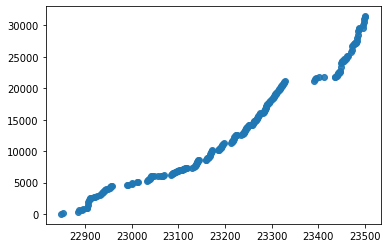

In [6]:
plt.scatter(golden['run_num'], np.cumsum(golden['total_q']), alpha=0.9);

Parameters([('amplitude', <Parameter 'amplitude', value=72125.15874319681 +/- 6.68e+03, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=9207.049751145369 +/- 143, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=1336.7020771622283 +/- 143, bounds=[0.0:inf]>), ('fwhm', <Parameter 'fwhm', value=3147.6927853431584 +/- 336, bounds=[-inf:inf], expr='2.3548200*sigma'>), ('height', <Parameter 'height', value=21.525945989372417 +/- 1.99, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>)])


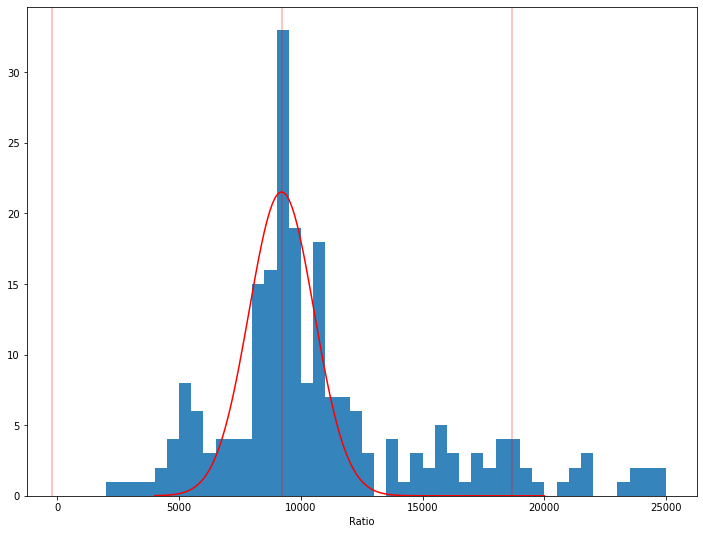

In [7]:
SIGMA = 3
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
bin_heights, bin_borders, _ = plt.hist(golden['ratio'], bins=50, histtype='stepfilled', alpha=0.9, range=[0, 25_000])#, range=[40_000, 80_000])

x = bin_borders[:-1]
y = bin_heights

mod = GaussianModel()
pars = mod.guess(y, x=x)
pars['center'].set(value=6_000)
out = mod.fit(y, pars, x=x)

xs=np.linspace(4_000, 20_000, 140)

plt.plot(xs, out.eval(x=xs), 'r-', label='best fit')

center = out.params['center'].value
fwhm = out.params['fwhm'].value

print(out.params)

plt.axvline(x=center, c='r', alpha=0.3)
plt.axvline(x=center+SIGMA*fwhm, c='r', alpha=0.3)
plt.axvline(x=center-SIGMA*fwhm, c='r', alpha=0.3)

plt.ylim(0)
plt.xlabel('Ratio')
plt.show()

9207.049751145369


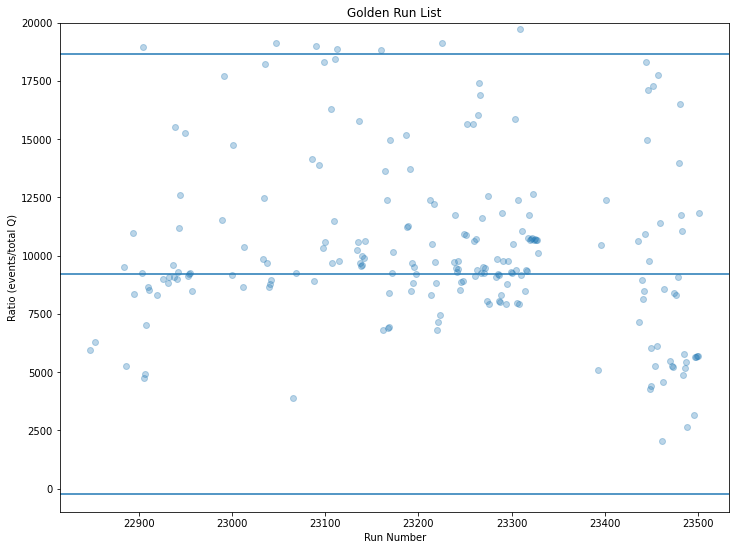

In [17]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden['run_num'], golden['ratio'], alpha=0.3)
print(center)
plt.axhline(y=center)
plt.axhline(y=center+SIGMA*fwhm)
plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden Run List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([40_000, 80_000])
plt.ylim([-1000, 20_000])
plt.show()


In [19]:
runs = golden[(golden['ratio'] >= center-SIGMA*fwhm) & (golden['ratio'] <= center+SIGMA*fwhm)].run_num
cut_out = golden[~golden.run_num.isin(runs.values)]
after_cut = golden[golden.run_num.isin(runs.values)]
print(len(after_cut))
after_cut.head()

199


,index,run_num,num_elec,num_of_events,total_q,ratio,sum_q,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,0,22848,206167,206200,34.602299,5959.141539,34.602299,2000-02-04 02:20:00.0,4817.26,5.0,3376.80,5996,5061135.0,beam_electron,H2_full
1,1,22853,1388871,1389076,220.698300,6294.004080,255.300599,2000-02-04 05:30:00.0,4817.26,5.0,3376.80,5996,4961938.0,beam_electron,H2_full
4,4,22884,617835,617950,64.988001,9508.678398,865.511502,2000-02-05 02:31:00.0,4817.26,4.0,3372.89,5996,2054237.0,beam_electron,H2_full
5,5,22886,1502327,1502621,284.785698,5276.321839,1150.297201,2000-02-05 04:08:00.0,4817.26,4.0,3376.80,5996,5015053.0,beam_electron,H2_full
6,6,22894,690769,690850,62.951100,10974.391256,1213.248300,2000-02-05 10:08:00.0,4817.26,4.0,3374.85,5996,3146650.0,beam_electron,H2_full


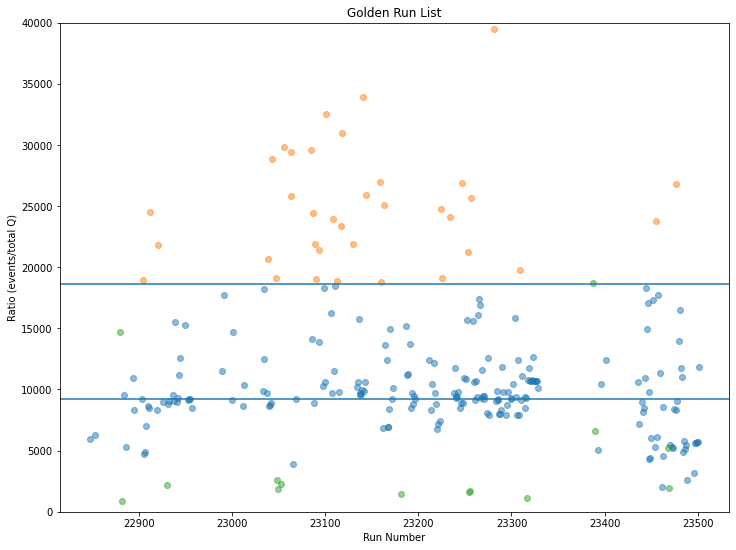

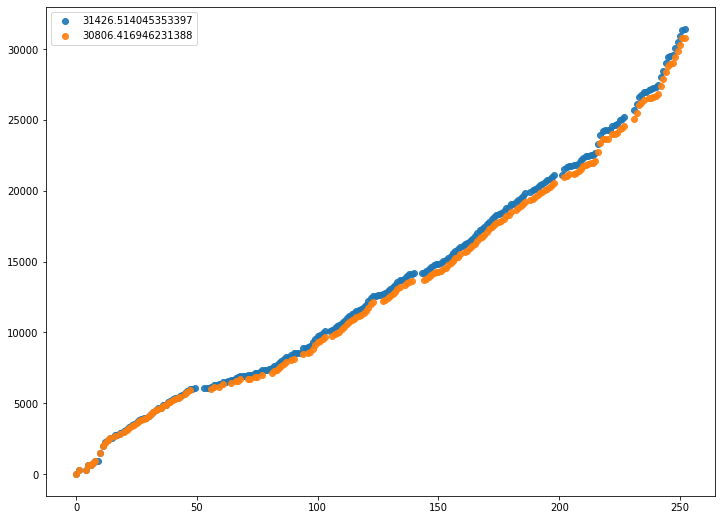

30806.416946231388


In [18]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(after_cut['run_num'], after_cut['ratio'], alpha=0.5)
plt.scatter(cut_out['run_num'], cut_out['ratio'], alpha=0.5)
plt.scatter(empty['run_num'], empty['ratio'], alpha=0.5)
plt.axhline(y=center)
plt.axhline(y=center+SIGMA*fwhm)
plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden Run List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([40_000, 80_000])
plt.ylim([0, 40_000])
plt.show()


fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden.index, np.cumsum(golden['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(golden.total_q))}')
plt.scatter(after_cut.index, np.cumsum(after_cut['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(after_cut.total_q))}')
plt.legend()
plt.show()


print(Q_tot := np.max(np.cumsum(after_cut.total_q)))
#print(Q_tot := np.max(np.cumsum(golden.total_q)))

In [11]:
def luminosity(Q_tot=2822.038E-6):
    Q_tot *= 1E-6
    # Q_tot = 15623.89E-6  # mCE-6 -> C
    # Q_tot = 2822.038E-6  # mCE-6 -> C
    l = 5  # cm
    rho = 0.0708  # g/cm3
    Avigadro = 6.022E23  # mol^−1
    qe = 1.602E-19  # C
    MH = 1.007  # g/mol
    conv_cm2_to_fm2 = 1E-39 # From wolfram alpha
    conv_cm2_to_mubarn = 1E-30

    return (Q_tot*l*rho*Avigadro)/(qe*MH) * conv_cm2_to_mubarn

In [12]:
print(f'{Q_tot:0.10f}')
print(f'{luminosity(Q_tot=Q_tot):0.2e}')
print(f'{luminosity():0.2e}')

31426.5140453534
4.15e+10
3.73e+03


In [22]:
from shutil import copyfile
import os
print(len(after_cut.run_num.unique()))
for run in after_cut.run_num.unique():
    #fil = int(fil)
    #src = f'/Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_{fil:02d}.root'
    #dst = f'/Users/tylern/Data/e1d/golden_run/h10_r{run}_{fil:02d}.root'
    # copyfile(src, dst)
    #command = f"rsync workstation_tunnel:/work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    command = f"rsync -ravP /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run;"
    #command = f"ln -s /work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root golden_run/;"
    print(command)
    #x = os.system(command)
    #print(x)
    

199
rsync -ravP /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r22848_*.root /Users/tylern/Data/e1d/golden_run;
rsync -ravP /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r22853_*.root /Users/tylern/Data/e1d/golden_run;
rsync -ravP /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r22884_*.root /Users/tylern/Data/e1d/golden_run;
rsync -ravP /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r22886_*.root /Users/tylern/Data/e1d/golden_run;
rsync -ravP /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r22894_*.root /Users/tylern/Data/e1d/golden_run;
rsync -ravP /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r22895_*.root /Users/tylern/Data/e1d/golden_run;
rsync -ravP /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r22904_*.root /Users/tylern/Data/e1d/golden_run;
rsync -ravP /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r22906_*.root /Users/tylern/Data/e1d/golden_run;
rsync -ravP /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r22907_*.root /Users/tylern/Data/e1d/golden_run;
rsync -ravP /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r22908_*.root /

In [14]:
for run in empty.run_num.unique():
    #fil = int(fil)
    #src = f'/Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_{fil:02d}.root'
    #dst = f'/Users/tylern/Data/e1d/golden_run/h10_r{run}_{fil:02d}.root'
    # copyfile(src, dst)
    #command = f"rsync workstation_tunnel:/work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    # command = f"rsync /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    command = f"ln -s /work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root empty/;"
    print(command)
    #x = os.system(command)
    #print(x)
    

ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22880_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22882_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22930_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r23048_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r23050_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r23053_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r23181_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r23254_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r23255_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r23317_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r23387_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r23390_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r23468_*.root empty/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r23469_*.root empty/;
